In [ ]:
!pip install pybaseball

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 415 kB 26.6 MB/s 
     |████████████████████████████████| 297 kB 64.5 MB/s 
     |████████████████████████████████| 856 kB 58.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import torch
import torch.nn as nn 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pybaseball
from torch.nn.functional import log_softmax, pad
import copy
import gc
import torch.optim as optim
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Data**

In [ ]:
#function to clean and organize data from statcast 
def organize_data(df):

    df = df.loc[df.balls < 4]
    df = df.loc[df.strikes < 3]

    df.dropna(subset = ['release_extension', 
                      'release_speed','release_spin_rate', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z'], axis = 0,
            inplace = True)

    #convert movement to inches instead of feet 
    df[['mx', 'mz']] = df[['pfx_x', 'pfx_z']].values * 12

    #one hot encode handedness
    pit_hand = pd.get_dummies(df['p_throws'], drop_first = False)
    bat_hand = pd.get_dummies(df['stand'], drop_first = False)
    df['pit_handR'] = pit_hand['R']
    df['bat_handR'] = bat_hand['R']
    df = df.drop(['p_throws', 'stand', 'pfx_x', 'pfx_z'], axis = 1)
    
    #remove bunts 
    df = df.loc[df.description.isin(['foul_bunt', 'bunt_foul_tip', 'missed_bunt']) == False]
    df = df.loc[df.events != 'sac_bunt']

    #define the pitch outcome 
    df['outcome'] = -1
    df.loc[df.type == 'B', 'outcome'] = 0 #called ball 
    df.loc[df.description == 'called_strike', 'outcome'] = 1 #called strike 
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'outcome'] = 2 #swm 
    df.loc[df.description.isin(['foul', 'foul_tip']), 'outcome'] = 3 #foul ball 

    #the other outcomes are all batted balls, which should either be outs or singles, doubles, triples, or home runs 
    df.loc[(df.type == 'X') & (df.events.isin(['field_out', 'force_out', 'field_error', 'grounded_into_double_play', 'sac_fly', 'fielders_choice', 
                                               'fielders_choice_out', 'double_play', 'other_out', 'triple_play', 
                                               'sac_fly_double_play'])), 'outcome'] = 4 # in play out 
    df.loc[(df.type == 'X') & (df.events == 'single'), 'outcome'] = 5 #single 
    df.loc[(df.type == 'X') & (df.events == 'double'), 'outcome'] = 6 # double 
    df.loc[(df.type == 'X') & (df.events == 'triple'), 'outcome'] = 7 #triple 
    df.loc[(df.type == 'X') & (df.events == 'home_run'), 'outcome'] = 8 #hr 

    #if outcome is still -1, drop it 
    df = df.loc[df.outcome != -1]

    #define an is_swing column 
    df['is_swing'] = -1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'swinging_strike', 'swinging_strike_blocked', 'foul_tip']), 'is_swing'] = 1
    df.loc[df.description.isin(['called_strike', 'ball', 'blocked_ball', 'hit_by_pitch', 'pitchout']), 'is_swing'] = 0

    #define an is_miss column 
    df['is_miss'] = -1 
    df.loc[df.is_swing == 0 , 'is_miss'] = 0
    df.loc[df.description.isin(['swinging_strike', 'swinging_strike_blocked']), 'is_miss'] = 1 
    df.loc[df.description.isin(['hit_into_play', 'foul', 'foul_tip']), 'is_miss'] = 0
    return df

In [ ]:
#columns needed from statcast 
needed_columns = ['game_date', 'game_year', 'game_pk', 'player_name', 'pitcher', 'batter', 'pitch_type', 'pitch_name', 'stand', 'p_throws', 'balls', 'strikes', 'release_speed', 
                  'release_spin_rate', 'release_extension', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
                  'plate_x', 'plate_z',  'type', 'events', 'description', 'woba_value', 'at_bat_number', 'pitch_number']

In [ ]:
#raw21 = pybaseball.statcast(start_dt = '2021-01-01', end_dt = '2021-12-31')

In [ ]:
#raw22 = pybaseball.statcast(start_dt = '2022-01-01', end_dt = '2022-11-15')

In [ ]:
#raw19 = pybaseball.statcast(start_dt = '2018-01-01', end_dt = '2020-12-01')

In [ ]:
from google.colab import drive
drive.mount('/drive')

#read in the data
raw22 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw22.csv')
raw21 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw21.csv')
raw19 = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/raw18_19_20.csv')
raw21 = raw21[needed_columns]
raw22 = raw22[needed_columns]
raw19 = raw19[needed_columns]

Mounted at /drive


In [ ]:
#clean the data

df21 = organize_data(raw21)
df22 = organize_data(raw22)
#df19 = organize_data(raw19)


all_data = df22.append(df21, ignore_index = True)
#all_data = all_data.append(df19, ignore_index = True)

In [ ]:
#min max scale variables 
standardizer = StandardScaler().fit(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']].values)

all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z',  'release_spin_rate']] = standardizer.transform(all_data[['release_speed', 'mx', 'mz', 
     'plate_x', 'plate_z', 'release_spin_rate']].values)

In [ ]:
#get the batter index
batter_indices = pd.DataFrame({'batter': all_data.batter.unique()})

batter_indices['batter_index'] = batter_indices.index.values

#merge 
all_data = all_data.merge(batter_indices, on = 'batter')

In [ ]:
bi = pd.read_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv')

In [ ]:
testing = bi.merge(batter_indices, how = 'inner', on = 'batter_index')

In [ ]:
testing.shape[0] == bi.shape[0] == batter_indices.shape[0]

True

**Data Loader**

In [ ]:
train = all_data.copy()

In [ ]:
batch_size = 256

#define a dataloader type thing. Basically we break down at bats by pitch sequence length. 
#then for each length we need to break down all the plate appearances of that length into batches.
pa_lengths = train.groupby(['game_pk', 'at_bat_number'], as_index = False).agg(seq_length = ('pitch_number', 'max'),
                                                                               pitches_recorded = ('pitch_number', 'count'))
#merge with train
train = train.merge(pa_lengths, how = 'inner', on = ['game_pk', 'at_bat_number'])
#make sure the pitches recorded matches the sequence length
train = train.loc[train.seq_length == train.pitches_recorded]

train['pa_id'] = [str(train.game_pk.values[i]) + '-' + str(train.at_bat_number.values[i]) for i in range(train.shape[0])]
#train is ordered from latest to earliest, but I think we want our sequence to go from earliest up top to latest on bottom 
train = train[::-1]

features = ['balls', 'strikes', 'release_speed', 'release_spin_rate', 'plate_x', 'plate_z',
                'mx', 'mz', 'pit_handR', 'bat_handR', 'batter_index']

loader_list = []
for l in pa_lengths.seq_length.unique():
  d = train.loc[train.seq_length == l]
  pas = list(d.pa_id.unique())
  #for each batch, I need to continue to add plate appearances until I hit my batch size 
  while len(pas) > 0:
    pas_for_batch = []
    s = 0 
    while s < batch_size:
      if len(pas) != 0:
        pas_for_batch.append(pas.pop(0))
        s += l
      else:
        s+=1

    #get the pas for this batch 
    batch_data = d.loc[d.pa_id.isin(pas_for_batch)]
    pa_id_and_pitch_num = batch_data[['pa_id', 'pitch_number']].values
    batch_x = batch_data[features].values
    batch_y = batch_data.outcome.values.astype(int)
    #reshape so that each pa is a separate entry in the batch
    batch_x = batch_x.reshape((len(pas_for_batch), l, len(features)))
    batch_y = batch_y.reshape((len(pas_for_batch),l))
    torch_batch_x = torch.tensor(batch_x, dtype = torch.float)
    torch_batch_y = torch.tensor(batch_y, dtype = torch.long)
    
    #append to list 
    loader_list.append((pa_id_and_pitch_num, torch_batch_x, torch_batch_y))


#shuffle the batches so that the RNN is trained on variable length sequences right from the get go 
#this will also give you a train test split 
import random
random.seed(51)
random.shuffle(loader_list)
train_loader_list = loader_list[:3*len(loader_list)//4]
test_loader_list = loader_list[3*len(loader_list)//4:]

**RNN**

In [ ]:
#helper classes 

batter_embedding_dim = 13
output_embedding_dim = 13

class InputEmbedding(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(InputEmbedding, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size
    #define batter embedding 
    self.batter_embedding = nn.Embedding(batter_indices.shape[0], embedding_dim = batter_embedding_dim)

    #define embedding for the pitch concatenated with the batter embedding concatenated with hidden state 
    self.ie1 = nn.Linear(in_features = len(features) - 1 + batter_embedding_dim + self.hidden_size, out_features = 512)
    self.ie2 = nn.Linear(512, 256)
    self.ie3 = nn.Linear(256, 128)
    self.ie4 = nn.Linear(128, 64)
    self.ie5 = nn.Linear(64, self.output_size)
    self.relu = nn.ReLU()
    
  def forward(self, x, hidden):
    #batter index is last column of x 
    batter_idx = x[:,-1].int()
    bat_emb = self.batter_embedding(batter_idx)

    #concatenate batter embedding and input and hidden state
    conc = torch.concat((x[:,:-1], bat_emb, hidden), dim = 1)
    
    #run through layers 
    conc = self.relu(self.ie1(conc))
    conc = self.relu(self.ie2(conc))
    conc = self.relu(self.ie3(conc))
    conc = self.relu(self.ie4(conc))
    return self.ie5(conc)


class HiddenStateUpdater(nn.Module):

    def __init__(self, hidden_size = 32, output_size = 9):
        super(HiddenStateUpdater, self).__init__()
        self.hidden_size = hidden_size 
        self.output_size = output_size
        #we need a target embedding 
        self.target_embedding = nn.Embedding(self.output_size, output_embedding_dim)
        #remember, we are going to take our pitch and our output embedding and concatenate them together for the hidden state, so we need features 
        #plus output embedding dim minus 1 for the batter index which we don't want to include.
        self.l1 = nn.Linear(len(features) - 1 + output_embedding_dim, 256)
        self.l2 = nn.Linear(256, 128)
        self.l3 = nn.Linear(128, 64)
        self.l4 = nn.Linear(64,32)
        self.proj = nn.Linear(32, self.hidden_size)
        self.relu = nn.ReLU()

    def forward(self, x, y):
        #get the output embedding 
        y = self.target_embedding(y)
        #concatenate onto x 
        x = torch.concat((x, y), dim = -1)
        #feed through network
        x = self.relu(self.l1(x))
        x = self.relu(self.l2(x)) 
        x = self.relu(self.l3(x))
        x = self.relu(self.l4(x))
        return self.proj(x)

In [ ]:
class RNN(nn.Module):
  def __init__(self, hidden_size = 32, output_size = 9):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size 
    self.output_size = output_size 

    self.input_embedding = InputEmbedding(self.hidden_size, self.output_size)
    self.h_update = HiddenStateUpdater(self.hidden_size, self.output_size)
    self.relu = nn.ReLU()

    #initialize batter embeddings 
    self.input_embedding.batter_embedding.weight.data.fill_(1.)

  def forward(self, x, hidden, y):
    #first we run x and hidden through the 'input embedding'
    output = self.input_embedding(x, hidden)

    #next, we run x and y through the hidden state updater, and we add that onto the old hidden state
    hidden += self.h_update(x[:,:-1], y)

    #return x and hidden 
    return output, hidden 

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) 

**Training**

In [ ]:
#define a training function 
def train(input, target, recurrent = True):
  #input and target are a batch, so they contain multiple plate appearances all of the same sequence length 

  #initialize hidden layers and gradients and loss 
  optimizer.zero_grad()
  input = input.to(device)
  target = target.to(device)
  loss = 0 

  input_length = input.size(1)

  #loop through the pas 
  for pa_num in range(input.size(0)):
    #initialize hidden state at the start of each pa 
    h0 = model.init_hidden()
    h0 = h0.to(device)
    pa = input[pa_num]
    pa_targets = target[pa_num]
    #loop through the sequence of pitches 
    for pitch in range(input_length):
      yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))

      #calculate loss for this pitch 
      loss += objective(yhat[0], pa_targets[pitch])

      #iterate hidden state to newly generated hidden state 
      if recurrent:
        h0 = h1 
      else:
        h0 = model.init_hidden().to(device)

  #now loss is the sum of loss for all pitches in batch
  loss.backward()
  optimizer.step()

  #return batch loss, which is loss per pitch 
  return loss.item() / (input.size(0) * input.size(1))


#define a similar eval function to be used to get loss on test set, so no trianing in this function 
def eval(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))

        loss += objective(yhat[0], pa_targets[pitch])

        if recurrent:
          h0 = h1 
        else:
          h0 = model.init_hidden().to(device)

    #return loss per pitch, so average loss over all the pitches in the sequence 
    return loss.item() / (input.size(0) * input.size(1)) 

def prediction_func(input, target, recurrent = True):
  #input is a batch of PAs 
  with torch.no_grad():
    #init 
    input = input.to(device)
    target = target.to(device)
    loss = 0

    input_length = input.size(1)

    #loop through pas in batch 
    preds = torch.empty((1,9)).to(device)
    for pa_num in range(input.size(0)):
      #initialize hidden state at start of each pa 
      h0 = model.init_hidden()
      h0 = h0.to(device)
      pa = input[pa_num]
      pa_targets = target[pa_num]
      for pitch in range(input_length):
        yhat, h1 = model(pa[pitch].unsqueeze(0), h0, pa_targets[pitch].unsqueeze(0))
        preds = torch.cat((preds, yhat), dim = 0)
        if recurrent:
          h0 = h1
        else:
          h0 = model.init_hidden().to(device)

    #return predictions
    return preds[1:,:]

In [ ]:
#define model and stuff
model = RNN(hidden_size = 32, output_size = 9).to(device)
model.load_state_dict(torch.load('/drive/My Drive/Colab Notebooks/sequencing_project/final_OP'))

#objective and optimizer 
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

#epochs 
epochs = 5

In [ ]:
tot_params = 0
for p in model.parameters():
  tot_params += np.prod(list(p.size()))
print('Model Parameters: ' + str(tot_params), ', Training Data: ' + str(all_data.shape[0]*3/4))

Model Parameters: 275179 , Training Data: 1108429.5


In [ ]:
batch_losses = []
val_losses = []
loss_avg = 0

for epoch in range(epochs):
  loop = tqdm(total = len(train_loader_list))
  for batch in range(len(train_loader_list)):
    ids, x, y = train_loader_list[batch] #might  be faster to send these to device now rather than in training function.

    #feed batch into training function 
    loss_ = train(x, y)

    loop.set_description('epoch:{}, loss:{:.4f}'.format(epoch, loss_))
    loop.update(1)

    batch_losses.append(loss_) 

    if batch == len(train_loader_list)-1 and epoch % 2 == 0:
      #run on validation set as well 
      val_set_losses = []
      for batch2 in test_loader_list:
        ids, x, y = batch2

        test_loss = eval(x, y)
        
        val_set_losses.append(test_loss)
      
      val_losses.append((len(batch_losses), np.mean(val_set_losses)))
      print('test loss: ' + str(np.mean(val_set_losses)))

  loop.close()

epoch:0, loss:1.0197: 100%|██████████| 4257/4257 [35:16<00:00,  2.01it/s]


test loss: 1.1294138410983476


epoch:2, loss:1.0059: 100%|██████████| 4257/4257 [33:59<00:00,  2.09it/s]


test loss: 1.1214977001640443


epoch:4, loss:0.9945: 100%|██████████| 4257/4257 [34:10<00:00,  2.08it/s]

test loss: 1.1155630965678416


The previous cell gives 5 epochs, which sets it at 10 epochs total.

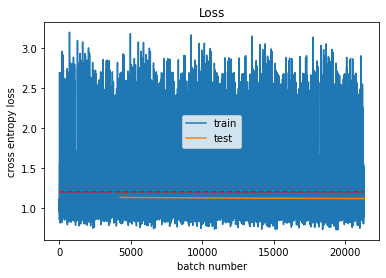

In [ ]:
a,b = zip(*val_losses)
plt.plot([i for i in range(len(batch_losses))], batch_losses, label = 'train')
plt.plot(a, b, label = 'test')
plt.plot([i for i in range(len(batch_losses))], [1.2 for _ in range(len(batch_losses))], 'r--')
plt.legend() 
plt.xlabel('batch number')
plt.ylabel('cross entropy loss')
plt.title('Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), '/drive/My Drive/Colab Notebooks/sequencing_project/final_OP')

**Calibration**

In [ ]:
#calibration 
def calibration(preds, actuals, groupsize = 30000, title = '', xlab = 'Predicted Rate', ylab = 'Actual Rate'):

    sorted_preds = preds[np.argsort(preds)]
    sorted_actuals = actuals[np.argsort(preds)]
    predicted = []
    actual = []
    numgroups = len(preds) // groupsize
    for i in range(numgroups):
        if i == numgroups-1:
            rows = [j for j in range(i*groupsize, len(preds))]
        else:
            rows = [j for j in range(i*groupsize, (i+1) * groupsize)]
        group_preds = sorted_preds[rows]
        group_actuals = sorted_actuals[rows]
        actual.append(np.mean(group_actuals))
        predicted.append(np.mean(group_preds))

    plt.plot(predicted, predicted, 'r--')
    plt.plot(predicted, actual, 'k.')
    plt.xlabel(xlab)
    plt.title(title)
    plt.ylabel(ylab)

In [ ]:
predicted_train_data = pd.DataFrame()
for batch in range(len(train_loader_list)):
  ids, x, y = train_loader_list[batch]
  
  ypred = prediction_func(x,y)

  y = y.view(y.size(0)*y.size(1))
  losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, y.cuda())
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  predicted_train_data = predicted_train_data.append(new_data, ignore_index = True)

In [ ]:
predicted_test_data = pd.DataFrame()
for batch in range(len(test_loader_list)):
  ids, x, y = test_loader_list[batch]
  
  ypred = prediction_func(x,y)

  y = y.view(y.size(0)*y.size(1))
  losses = nn.CrossEntropyLoss(reduction = 'none')(ypred, y.cuda())
  new_data = pd.DataFrame({'pa_id': ids[:,0], 'pitch_number': ids[:,1], 'outcome': y.cpu().numpy()})
  new_data[['o0', 'o1', 'o2', 'o3', 'o4', 'o5', 'o6', 'o7', 'o8']] = nn.functional.softmax(ypred, dim = 1).detach().cpu().numpy()
  new_data['cross_entropy_loss'] = losses.detach().cpu().numpy()
  predicted_test_data = predicted_test_data.append(new_data, ignore_index = True)

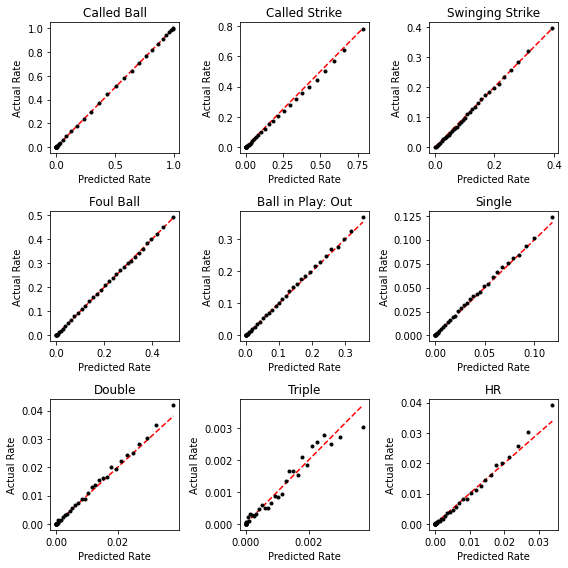

In [ ]:
#RNN calibration, train set
fig= plt.figure(figsize=(8,8))
ax1 = plt.subplot(331)
ax1 = calibration(predicted_train_data.o0.values, (predicted_train_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(predicted_train_data.o1.values, (predicted_train_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(predicted_train_data.o2.values, (predicted_train_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(predicted_train_data.o3.values, (predicted_train_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(predicted_train_data.o4.values, (predicted_train_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(predicted_train_data.o5.values, (predicted_train_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(predicted_train_data.o6.values, (predicted_train_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(predicted_train_data.o7.values, (predicted_train_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(predicted_train_data.o8.values, (predicted_train_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

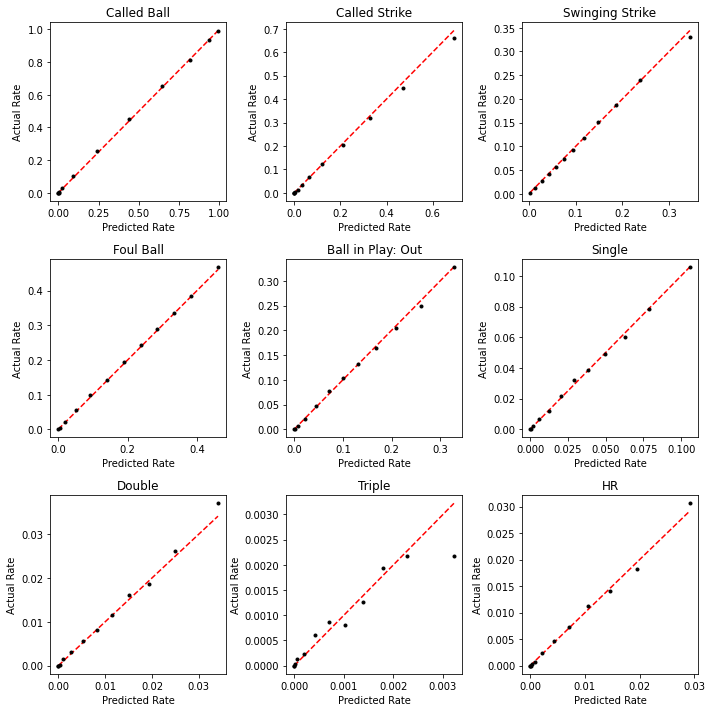

In [ ]:
#RNN calibration, test set
fig= plt.figure(figsize=(10,10))
ax1 = plt.subplot(331)
ax1 = calibration(predicted_test_data.o0.values, (predicted_test_data.outcome.values == 0).astype(bool).astype(int), title = 'Called Ball')

ax2 = plt.subplot(332)
ax2 = calibration(predicted_test_data.o1.values, (predicted_test_data.outcome.values == 1).astype(bool).astype(int), title = 'Called Strike')

ax3 = plt.subplot(333)
ax3 = calibration(predicted_test_data.o2.values, (predicted_test_data.outcome.values == 2).astype(bool).astype(int), title = 'Swinging Strike')

ax4 = plt.subplot(334)
ax4 = calibration(predicted_test_data.o3.values, (predicted_test_data.outcome.values == 3).astype(bool).astype(int), title = 'Foul Ball')

ax5 = plt.subplot(335)
ax5 = calibration(predicted_test_data.o4.values, (predicted_test_data.outcome.values == 4).astype(bool).astype(int), title = 'Ball in Play: Out')

ax6 = plt.subplot(336)
ax6 = calibration(predicted_test_data.o5.values, (predicted_test_data.outcome.values == 5).astype(bool).astype(int), title = 'Single')

ax7 = plt.subplot(337)
ax7 = calibration(predicted_test_data.o6.values, (predicted_test_data.outcome.values == 6).astype(bool).astype(int), title = 'Double')

ax8 = plt.subplot(338)
ax8 = calibration(predicted_test_data.o7.values, (predicted_test_data.outcome.values == 7).astype(bool).astype(int), title = 'Triple')

ax9 = plt.subplot(339)
ax9 = calibration(predicted_test_data.o8.values, (predicted_test_data.outcome.values == 8).astype(bool).astype(int), title = 'HR')

plt.tight_layout()
plt.show()

We often like to predict swings given a pitch, and we like to predict swing and miss given that the batter swang, so check that the model is well calibrated in those predictions

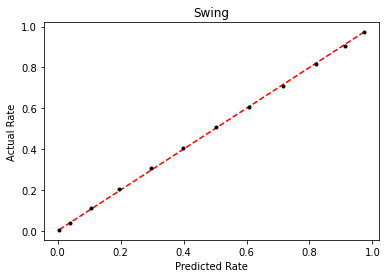

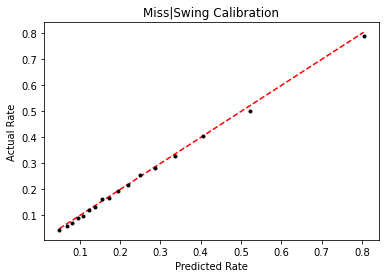

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

#swing calibration: test set 
predicted_test_data['is_swing'] = 0
predicted_test_data.loc[predicted_test_data.outcome > 1, 'is_swing'] = 1

calibration(predicted_test_data[['o2','o3','o4','o5','o6','o7','o8']].sum(axis=1).values, predicted_test_data.is_swing.values, title = 'Swing')
plt.show()

#miss given swing calibration: test set 
d = predicted_test_data.loc[predicted_test_data.is_swing == 1]
d['is_miss'] = 0
d.loc[d.outcome == 2, 'is_miss'] = 1

calibration(d.o2.values /d[['o2','o3','o4','o5','o6','o7','o8']].sum(axis=1).values , d.is_miss.values, title = 'Miss|Swing Calibration', groupsize = 10000)
plt.show()

In [ ]:
predicted_train_data.cross_entropy_loss.mean(), predicted_test_data.cross_entropy_loss.mean()

NameError: ignored

In [ ]:
#batter_indices.to_csv('/drive/My Drive/Colab Notebooks/sequencing_project/batter_indices_final_model.csv', index = False)